# QuantumSim - Noisy Circuit - Nico
Author: Nico Kuijpers<br>
Date: May 28, 2025

In this notebook we use QuantumSim. We use this version from Github:<br>
https://github.com/nicokuijpers/QuantumSim/blob/main/quantumsim.py

Any changes made to this version from Github are explicitly mentioned.


In [1]:
from quantumsim import *

## Changes to quantumsim.py

### Remove check unitary operation

Class StateVector, method `measure`

```Python
    def apply_unitary_operation(self, operation):
        # Check if operation is a unitary matrix
        # REMOVED BY NICO
        #if not np.allclose(np.eye(2**self.N), np.dot(np.conj(operation.T), operation)):
        #    raise ValueError("Input matrix is not unitary")
        self.state_vector = np.dot(operation, self.state_vector)
```

The check for unitary operation in method `apply_unitary_operation` has been removed because an operation matrix for a noisy gate need not be unitary. 
The original idea was to use method `apply_noisy_operation` for noisy operations only. Probably it is better to not make this distinction and remove 
method `apply_noisy_operation` altoghether. Another good reason to remove the check is that it is computationally very expensive (as was shown by Wouter).

Here is the code for method `apply_noisy_operation`. This method can (hopefully) be removed.

```Python
    def apply_noisy_operation(self, operation):
        # A noisy operation does not have to be a unitary matrix
        self.state_vector = np.dot(operation, self.state_vector)
```

### NoisyCircuit
In `quantumsim.py` there is a class NoisyCircuit. It would be wise to remove this class to avoid confusion. Thus, class Circuit should be able to execute
all noisy gate operations.

#### Remark
Class Circuit supports both Operations and Instructions. It is better to use Instructions only and remove the code regarding Operations 
(and thus save memory usage).
Use flag `save_instructions=True` in the constructor of class Circuit, because noisy operations are only supported as Instructions in class Circuit. 
For class NoisyCircuit it holds that only Operations are supported.

#### Remark
When removing class NoisyCircuit, also method `create_noisy_circuit` should be removed from class Circuit.

```Python
    def create_noisy_circuit(self):
        noisy_circuit = NoisyCircuit(self.N)
        for operation, description, gate in zip(self.operations, self.descriptions, self.gates):
            noisy_circuit.operations.append(operation)
            noisy_circuit.descriptions.append(description)
            noisy_circuit.gates.append(gate)
        return noisy_circuit
```

#### Error in Github quantumsim.py
It turns out that there is an error in class Circuit that does not occur in class NoisyCircuit. This error is illustrated in the example below: 
when creating a figure showing the probabilities for each (intermediate) quantum state, the last state is not visualised for noisy operations when using Circuit.

This error is solved as follows: in private method `__noisy_instruction_handler` of class Circuit add the following code at the end.

```Python
        self.quantum_states.append(self.state_vector.get_quantum_state())
```

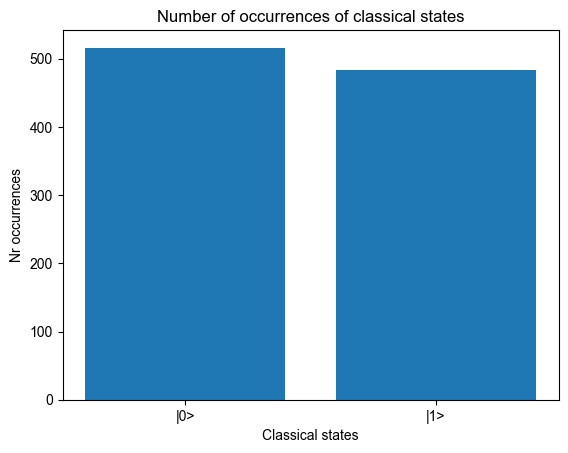

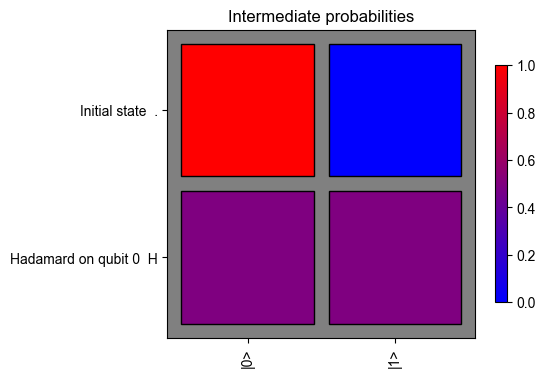

In [2]:
circuit = Circuit(1, save_instructions=True)
circuit.hadamard(0)
result = QuantumUtil.run_circuit(circuit)
QuantumUtil.histogram_of_classical_states(result)
QuantumUtil.show_all_probabilities(circuit)

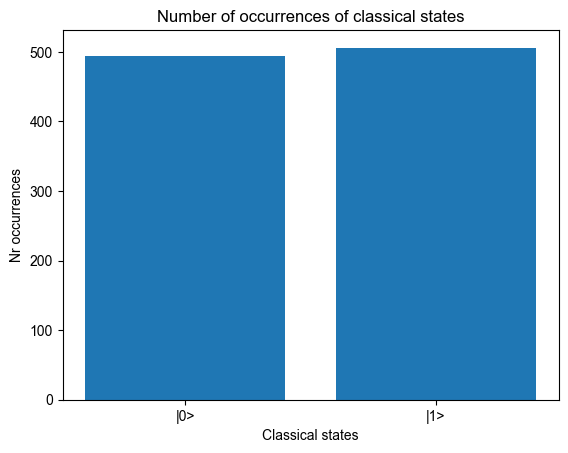

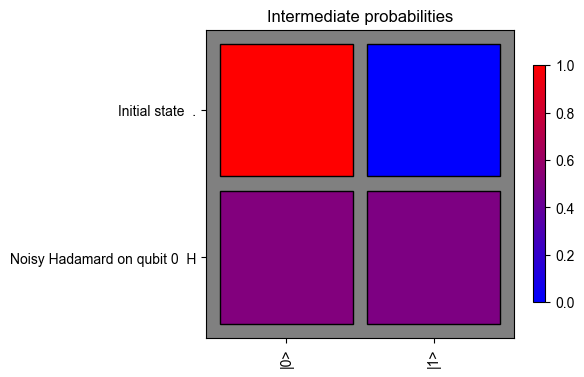

In [3]:
circuit = Circuit(1, save_instructions=True)
circuit.noisy_hadamard(0)
result = QuantumUtil.run_circuit(circuit)
QuantumUtil.histogram_of_classical_states(result)
QuantumUtil.show_all_probabilities(circuit)

## Plot probability distribution (ideal gates)
With function `plot_probability_distribution` a bar plot can be created to show the distribution of probabilies corresponding to a given state vector.

In [4]:
def plot_probability_distribution(state_vector):
    """
    Create a bar plot showing probabilities of occurrence of classical states.

    Parameters:
    state_vector : vector of 2^N complex numbers representing the quantum state of a circuit of size N
    """

    # Determine the number of qubits
    nr_qubits = int(np.log2(len(state_vector)))

    # Determine the probabilities
    probalities = np.square(np.abs(state_vector)).flatten()

    # For a noisy circuit, the sum of probabilities may not be equal to one
    probalities = probalities / np.sum(probalities)

    # Create the labels for the x-axis
    labels = [Dirac.state_as_string(i, nr_qubits) for i in range(2**nr_qubits)]

    # Show the distribution of probabilities using a bar plot
    plt.bar(labels, probalities)
    plt.xlabel('Classical states')
    plt.ylabel('Probability')
    plt.title('Distribution of probabilities')

Below a circuit is created with a Hadamard operation and the probability distribution is shown. 
Note that since the Hadamard operation is ideal, the probability distribution should always be 0.5 $\ket{0}$ and 0.5 $\ket{1}$.

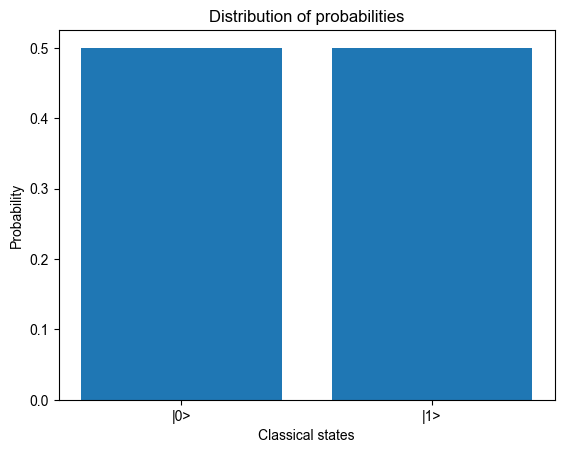

In [5]:
circuit = Circuit(1, save_instructions=True)
circuit.hadamard(0)
circuit.execute()
state_vector = circuit.state_vector.get_quantum_state()
plot_probability_distribution(state_vector)

## Plot probability distribution (noisy gates)
When at least one gate of the circuit is a *noisy gate*, the distribution of probabilities may vary in between different executions of the circuit.

With function `plot_probability_distribution_noise` a bar plot can be created to show the mean and standard deviation of probabilies corresponding
to a given list state vectors. The state vectors are obtained by a number executions of the circuit.

In [6]:
def plot_probability_distribution_noise(state_vectors):
    """
    Create a bar plot showing average and standard deviation of 
    probabilities of occurrences of classical states.

    Parameters:
    state_vectors : list of state vectors. 
    
    A state vector is an array of 2^N complex numbers representing the quantum state of a circuit of size N
    """

    # Determine the number of qubits
    nr_qubits = int(np.log2(len(state_vectors[0])))

    # Determine the probabilities
    probalities = np.square(np.abs(state_vectors))
    
    # For a noisy circuit, the sum of probabilities may not be equal to one
    probalities = [prob / np.sum(prob) for prob in probalities]

    # Compute mean and standard deviation for each index
    mean_probalities = np.mean(probalities, axis=0).flatten()
    std_probabilities = np.std(probalities, axis=0).flatten()

    # Create the labels for the x-axis
    labels = [Dirac.state_as_string(i, nr_qubits) for i in range(2**nr_qubits)]

    # Show the distribution of probabilities using a bar plot
    plt.bar(labels, mean_probalities, yerr=std_probabilities)
    plt.xlabel('Classical states')
    plt.ylabel('Probability')
    plt.title('Mean and standard deviation of probabilities')

Below a function is defined to execute a circuit a number times and store the resulting state vectors in a list.

In [7]:
def execute_circuit(circuit:Circuit, nr_executions=100):
    result = []
    for i in range(nr_executions):
        circuit.execute()
        result.append(circuit.state_vector.get_quantum_state())
    return result

Below a circuit is created with a noisy Hadamard operation. The circuit is executed 100 times and the resulting state vectors are stored in a list.
Using function `plot_probability_distribution_noise`, the mean and standard deviation of the probabilities are shown for each possible
classical state. 
Note that although the Hadamard operation is noisy, the means of the probabilities should be close to 0.5 $\ket{0}$ and 0.5 $\ket{1}$ for a large
number of executions. Standard deviation are non-zero and indicated by error bars.

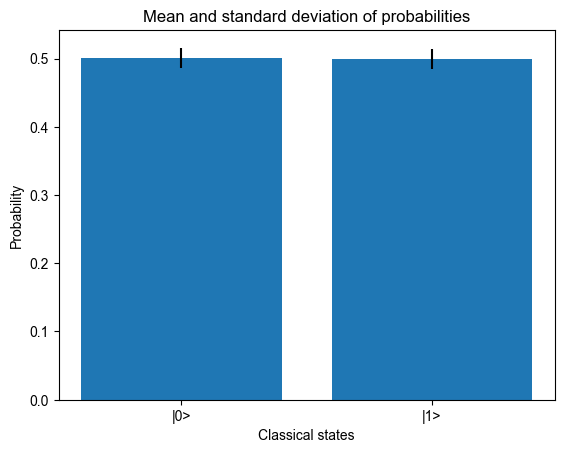

In [8]:
circuit = Circuit(1, save_instructions=True)
circuit.noisy_hadamard(0)
state_vectors = execute_circuit(circuit, 100)
plot_probability_distribution_noise(state_vectors)

## Noisy Hadamard gate
Below we show the effect of a noisy Hadamard gate with *noise_factor* 10. Thus, the effect of noise is greatly exaggerated.

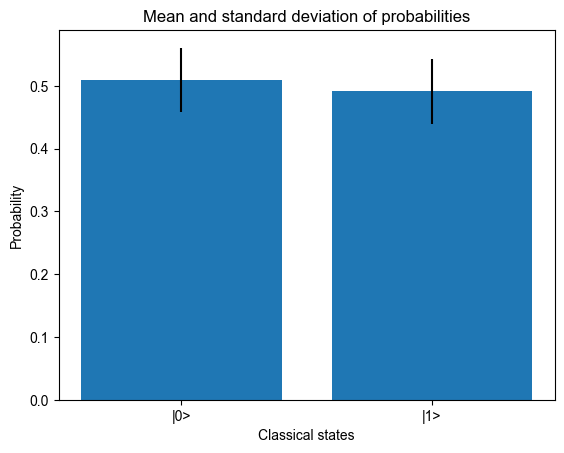

In [9]:
circuit = Circuit(1, save_instructions=True, noise_factor=10)
circuit.noisy_hadamard(0)
state_vectors = execute_circuit(circuit, 100)
plot_probability_distribution_noise(state_vectors)

## Bell state
Below, an ideal circuit is created and a Bell state is shown.

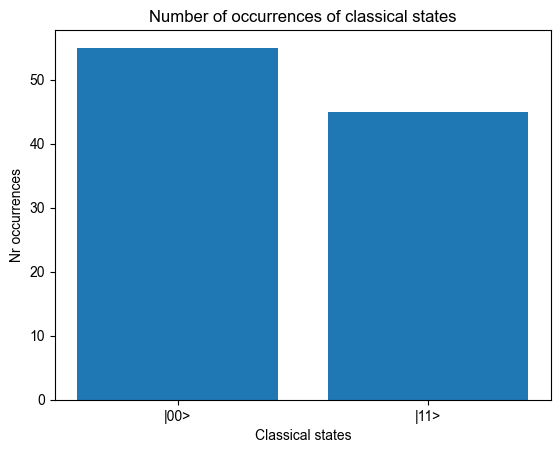

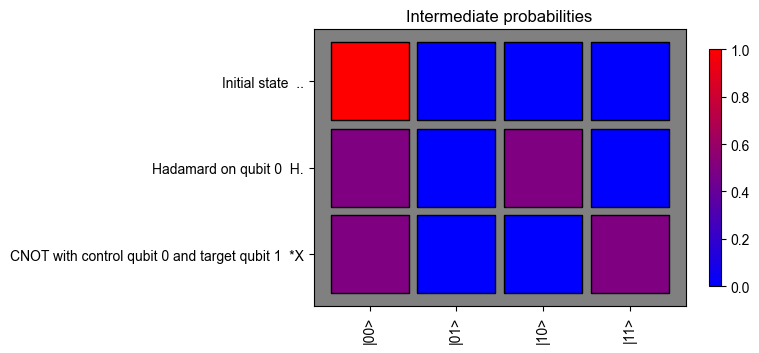

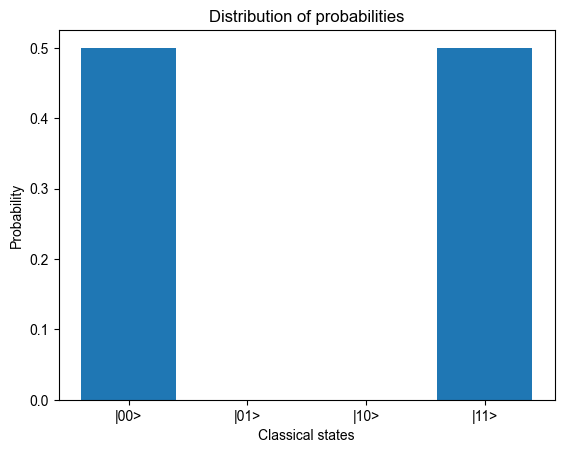

In [10]:
circuit = Circuit(2, save_instructions=True)
circuit.hadamard(0)
circuit.cnot(0,1)
result = QuantumUtil.run_circuit(circuit, nr_runs=100)
QuantumUtil.histogram_of_classical_states(result)
QuantumUtil.show_all_probabilities(circuit)
state_vector = circuit.state_vector.get_quantum_state()
plot_probability_distribution(state_vector)


Below, the Hadamard operation is replaced by the noisy Hadamard operation, but the CNOT operation is still ideal.
As above, the effect of noisy operations is exaggerated by setting *noise_factor* to 10.

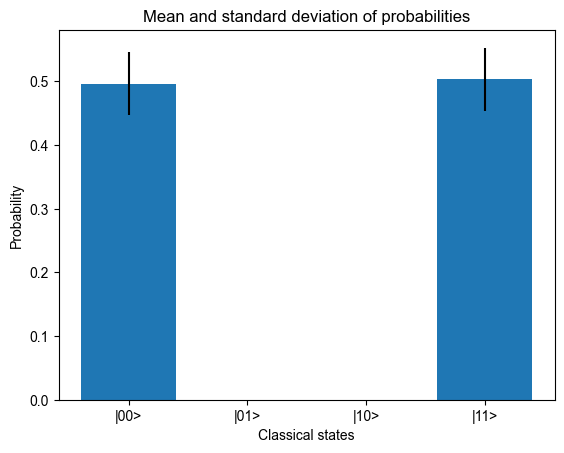

In [11]:
circuit = Circuit(2, save_instructions=True, noise_factor=10)
circuit.noisy_hadamard(0)
circuit.cnot(0,1)
state_vectors = execute_circuit(circuit, 100)
plot_probability_distribution_noise(state_vectors)

Below, the CNOT operation is replaced by the noisy CNOT operation, but the Hadamard operation is still ideal.
As above, the effect of noisy operations is exaggerated by setting *noise_factor* to 10.

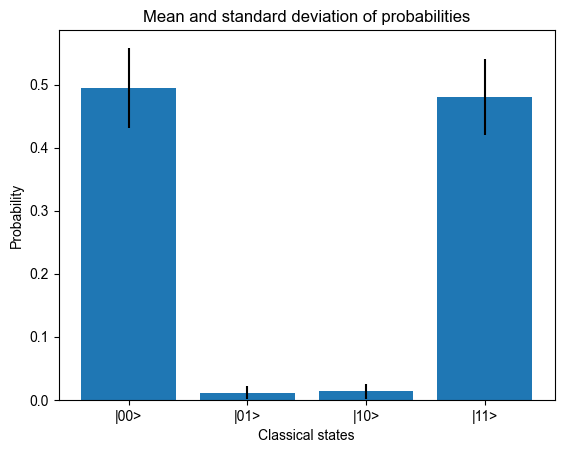

In [12]:
circuit = Circuit(2, save_instructions=True, noise_factor=10)
circuit.hadamard(0)
circuit.noisy_cnot(0,1)
state_vectors = execute_circuit(circuit, 100)
plot_probability_distribution_noise(state_vectors)

Below, Both the Hadmard and the CNOT operations ar replaced with their noisy counterparts.
As above, the effect of noisy operations is exaggerated by setting *noise_factor* to 10.

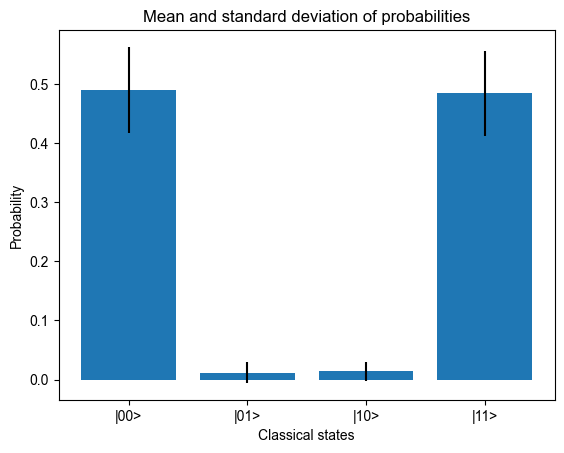

In [13]:
circuit = Circuit(2, save_instructions=True, noise_factor=10)
circuit.noisy_hadamard(0)
circuit.noisy_cnot(0,1)
state_vectors = execute_circuit(circuit, 100)
plot_probability_distribution_noise(state_vectors)

## Pauli X operation
Below we show the means and standard deviations of the probabilities after permorming 1 Pauli X operation. 
We show both the ideal Pauli X and the noisy Pauli X operation.
As before, the effect of noisy operations is exaggerated by setting *noise_factor* to 10.

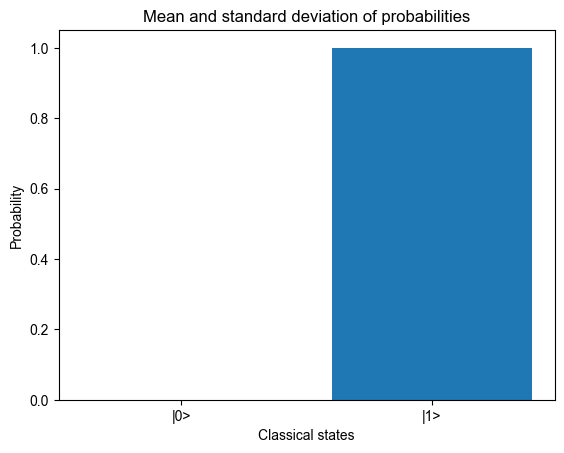

In [14]:
circuit = Circuit(1, save_instructions=True)
circuit.pauli_x(0)
state_vectors = execute_circuit(circuit, 100)
plot_probability_distribution_noise(state_vectors)

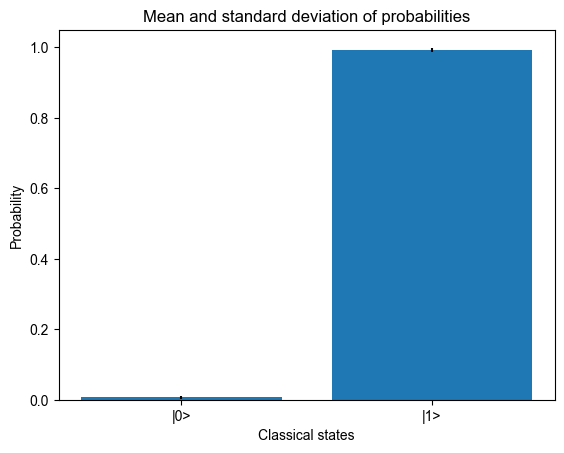

In [15]:
circuit = Circuit(1, save_instructions=True, noise_factor=10)
circuit.noisy_pauli_x(0)
state_vectors = execute_circuit(circuit, 100)
plot_probability_distribution_noise(state_vectors)

Below we show the means and standard deviations of the probabilities after performing 120 Pauli X operations. We show both the ideal situation and the noisy situation.

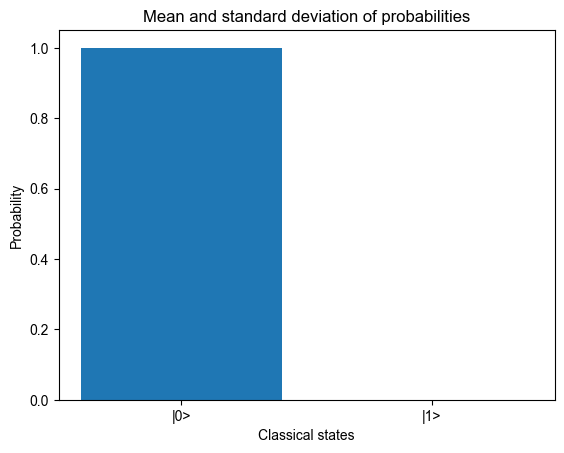

In [16]:
nr_pauli_x = 120

circuit = Circuit(1, save_instructions=True)
for i in range(nr_pauli_x):
    circuit.pauli_x(0)

state_vectors = execute_circuit(circuit, 100)
plot_probability_distribution_noise(state_vectors)

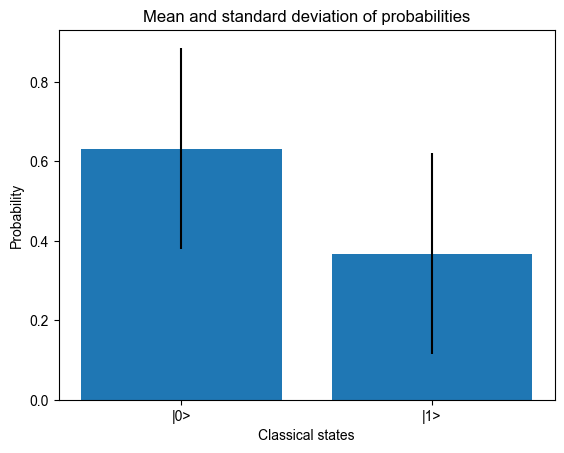

In [17]:
nr_pauli_x = 120

circuit = Circuit(1, save_instructions=True, noise_factor=10)
for i in range(nr_pauli_x):
    circuit.noisy_pauli_x(0)

state_vectors = execute_circuit(circuit, 100)
plot_probability_distribution_noise(state_vectors)

## Pauli Z operation
Below we show the means and standard deviations of the probabilities after permorming a Hadamard, Pauli Z, and another Hadamard operation. 
We show both the ideal Pauli Z and the noisy Pauli Z operation. For the Hadamard operation, the ideal gate operation is used.
As before, the effect of noisy operations is exaggerated by setting *noise_factor* to 10.

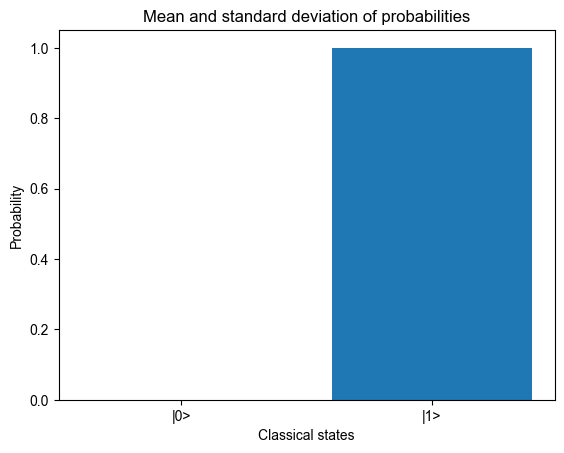

In [18]:
circuit = Circuit(1, save_instructions=True)
circuit.hadamard(0)
circuit.pauli_z(0)
circuit.hadamard(0)
state_vectors = execute_circuit(circuit, 100)
plot_probability_distribution_noise(state_vectors)

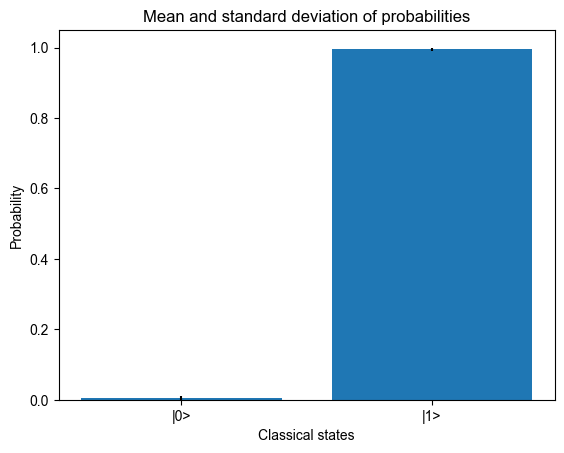

In [19]:
circuit = Circuit(1, save_instructions=True, noise_factor=10)
circuit.hadamard(0)
circuit.noisy_pauli_z(0)
circuit.hadamard(0)
state_vectors = execute_circuit(circuit, 100)
plot_probability_distribution_noise(state_vectors)

Below we show the means and standard deviations of the probabilities after performing 120 Pauli Z operations. We show both the ideal situation and the noisy situation.

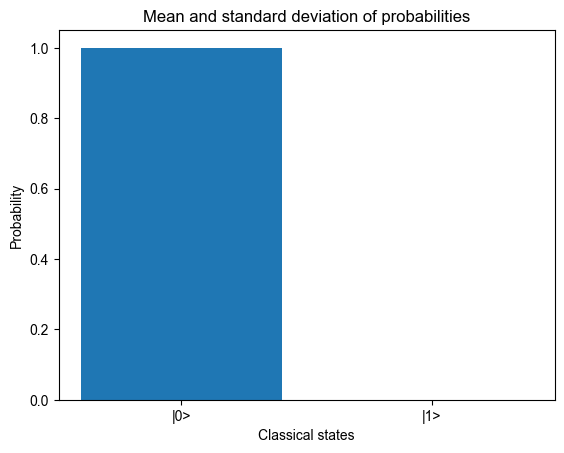

In [20]:
nr_pauli_z = 120

circuit = Circuit(1, save_instructions=True)
circuit.hadamard(0)
for i in range(nr_pauli_x):
    circuit.pauli_z(0)
circuit.hadamard(0)

state_vectors = execute_circuit(circuit, 100)
plot_probability_distribution_noise(state_vectors)

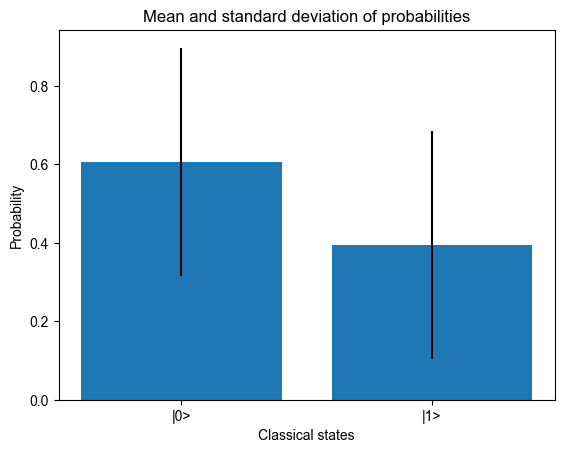

In [21]:
nr_pauli_z = 120

circuit = Circuit(1, save_instructions=True, noise_factor=10)
circuit.hadamard(0)
for i in range(nr_pauli_x):
    circuit.noisy_pauli_z(0)
circuit.hadamard(0)

state_vectors = execute_circuit(circuit, 100)
plot_probability_distribution_noise(state_vectors)

## Rotation about the X-axis

For rotation about the X-axis, add method `noisy_rotate_x` to class Circuit.

```Python
    def noisy_rotate_x(self, theta:float, q: int, p: float = None, T1: float = None, T2: float = None):
        """Adds a noisy rotate X gate to the circuit

        Args:
            theta (float): Angle of rotation on the Bloch sphere.
            q (int): Qubit to operate on.
            p (float): Single-qubit depolarizing error probability.
            T1 (float): Qubit's amplitude damping time in ns.
            T2 (float): Qubit's dephasing time in ns.
        """
        # If any noise parameter is None use the generated value
        if p is None:
            p = self.parameters["p"][q] * self.noise_factor
        if T1 is None:
            T1 = self.parameters["T1"][q] / self.noise_factor
        if T2 is None:
            T2 = self.parameters["T2"][q] / self.noise_factor

        self.instructions.append(NoisyRotateX(theta, q, self.N, p, T1, T2))
        self.descriptions.append(f"Noisy Rotate X with theta = {theta/np.pi:.3f} {pi_symbol} on qubit {q}")
        gate_as_string = '.'*self.N
        gate_as_list = list(gate_as_string)
        gate_as_list[q] = 'R'
        gate_as_string = ''.join(gate_as_list)
        self.gates.append(gate_as_string)
```

And add class NoisyRotateX

```Python
Class NoisyRotateX(NoisyGateInstruction):
    def __init__(self, theta:float, q: int, totalQubits: int, p: float = None, T1: float = None, T2: float = None, ):
        self.theta = theta
        self.q = q
        self.N = totalQubits
        self.p = p
        self.T1 = T1
        self.T2 = T2
        
    def setPhi(self, phi: float):
        self.phi = phi

    def getNoisyOperation(self) -> CircuitUnitaryOperation:
        return CircuitUnitaryOperation.get_combined_operation_for_qubit(NoisyGate.construct(self.theta, self.phi, self.p, self.T1, self.T2),self.q, self.N)
```

And extend private method `__noisy_instruction_handler` of class Circuit with

```Python
        elif isinstance(instruction, NoisyRotateX):
            # Define phi to construct Rotate X
            instruction.setPhi(-self.phi[instruction.q])
            self.state_vector.apply_noisy_operation(instruction.getNoisyOperation())

```

Below we show the means and standard deviations of the probabilities after permorming 1 rotate X operation with $\theta = \frac{\pi}{3}$. 
We show both the ideal rotate X and the noisy rotate X operation.
As before, the effect of noisy operations is exaggerated by setting *noise_factor* to 10.

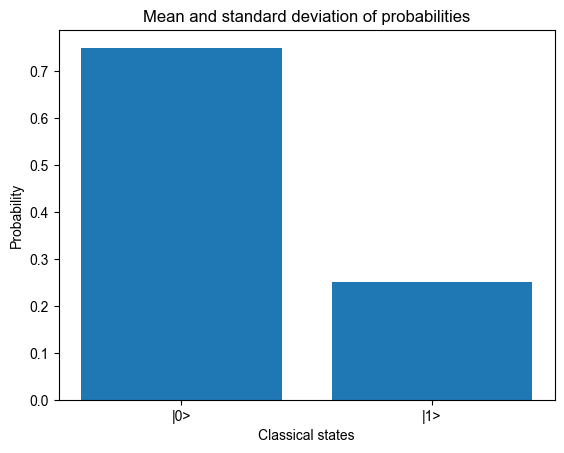

In [22]:
theta = np.pi/3
circuit = Circuit(1, save_instructions=True)
circuit.rotate_x(theta, 0)
state_vectors = execute_circuit(circuit, 100)
plot_probability_distribution_noise(state_vectors)

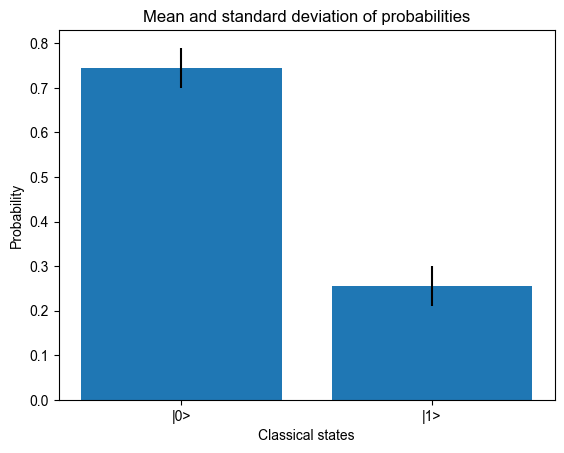

In [23]:
theta = np.pi/3
circuit = Circuit(1, save_instructions=True, noise_factor=10)
circuit.noisy_rotate_x(theta, 0)
state_vectors = execute_circuit(circuit, 100)
plot_probability_distribution_noise(state_vectors)

## Rotation about the Z-axis

For rotation about the Z-axis, add method `noisy_rotate_z` to class Circuit.

```Python
    def noisy_rotate_z(self, theta:float, q: int, p: float = None, T1: float = None, T2: float = None):
        """Adds a noisy rotate Z gate to the circuit

        Args:
            theta (float): Angle of rotation on the Bloch sphere.
            q (int): Qubit to operate on.
            p (float): Single-qubit depolarizing error probability.
            T1 (float): Qubit's amplitude damping time in ns.
            T2 (float): Qubit's dephasing time in ns.
        """
        # If any noise parameter is None use the generated value
        if p is None:
            p = self.parameters["p"][q] * self.noise_factor
        if T1 is None:
            T1 = self.parameters["T1"][q] / self.noise_factor
        if T2 is None:
            T2 = self.parameters["T2"][q] / self.noise_factor

        self.instructions.append(NoisyRotateZ(theta, q, self.N, p, T1, T2))
        self.descriptions.append(f"Noisy Rotate Z with theta = {theta/np.pi:.3f} {pi_symbol} on qubit {q}")
        gate_as_string = '.'*self.N
        gate_as_list = list(gate_as_string)
        gate_as_list[q] = 'R'
        gate_as_string = ''.join(gate_as_list)
        self.gates.append(gate_as_string)
```

And add class NoisyRotateZ

```Python
class NoisyRotateZ(NoisyGateInstruction):
    def __init__(self, theta:float, q: int, totalQubits: int, p: float = None, T1: float = None, T2: float = None, ):
        self.theta = theta
        self.q = q
        self.N = totalQubits
        self.p = p
        self.T1 = T1
        self.T2 = T2
        
    def setPhi(self, phi: float):
        self.phi = phi

    def getNoisyOperation(self) -> CircuitUnitaryOperation:
        return CircuitUnitaryOperation.get_combined_operation_for_qubit(NoisyGate.construct(self.theta, self.phi, self.p, self.T1, self.T2),self.q, self.N)
```

And extend private method `__noisy_instruction_handler` of class Circuit with

```Python
        elif isinstance(instruction, NoisyRotateZ):
            instruction.setPhi(-self.phi[instruction.q])
            self.state_vector.apply_unitary_operation(CircuitUnitaryOperation.get_combined_operation_for_hadamard(instruction.q, instruction.N))
            self.state_vector.apply_noisy_operation(instruction.getNoisyOperation())
            self.state_vector.apply_unitary_operation(CircuitUnitaryOperation.get_combined_operation_for_hadamard(instruction.q, instruction.N))

```

Below we show the means and standard deviations of the probabilities after permorming 1 rotate Z operation with $\theta = \frac{\pi}{3}$. 
We show both the ideal rotate Z and the noisy rotate Z operation.
As before, the effect of noisy operations is exaggerated by setting *noise_factor* to 10.

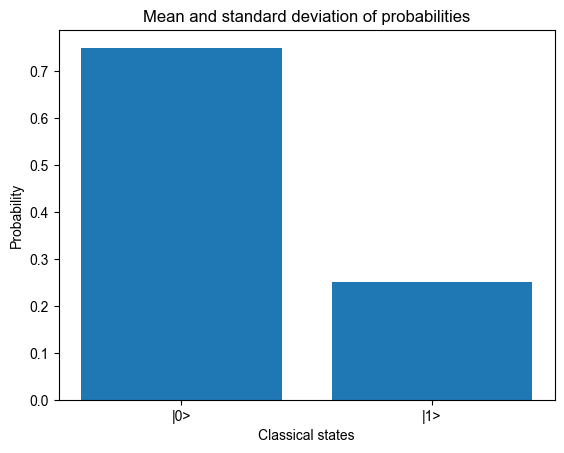

In [24]:
theta = np.pi/3
circuit = Circuit(1, save_instructions=True)
circuit.hadamard(0)
circuit.rotate_z(theta, 0)
circuit.hadamard(0)
state_vectors = execute_circuit(circuit, 100)
plot_probability_distribution_noise(state_vectors)

In [ ]:
theta = np.pi/3
circuit = Circuit(1, save_instructions=True, noise_factor=0)
circuit.hadamard(0)
circuit.noisy_rotate_z(theta, 10)
circuit.hadamard(0)
state_vectors = execute_circuit(circuit, 100)
plot_probability_distribution_noise(state_vectors)

ZeroDivisionError: float division by zero

## QAOA